In [2]:
import os
from pathlib import Path
import cv2
import pandas as pd
import numpy as np
from statistics import median, mean
import seaborn as sns
from dataclasses import asdict
import matplotlib.pyplot as plt
import random
# os.chdir("/home/weedsci/matt/SemiF-SyntheticPipeline")
# from semif_utils.utils import get_cutout_meta

In [3]:
def cutoutmeta2csv(cutoutdir, batch_id, save_df=False):
    # Get all json files
    metas = [x for x in Path(f"{cutoutdir}{batch_id}/").glob("*.json")]
    cutouts = []
    for meta in metas:
        # Get dictionaries
        cutout = asdict(get_cutout_meta(meta))
        row = cutout["cutout_props"]
        cls = cutout["cls"]
        # Extend nested dicts to single column header
        for ro in row:
            rec = {ro: row[ro]}
            cutout.update(rec)
            for cl in cls:
                spec = {cl: cls[cl]}
                cutout.update(spec)
        # Remove duplicate nested dicts
        cutout.pop("cutout_props")
        cutout.pop("cls")
        # Create and append df
        cutdf = pd.DataFrame(cutout, index=[0])
        cutouts.append(cutdf)
    # Concat and reset index of main df
    cutouts_df = pd.concat(cutouts)
    cutouts_df = cutouts_df.reset_index()
    # Save dataframe
    if save_df:
        cutouts_df.to_csv(f"{cutoutdir}/{batch_id}.csv", index=False)
    return cutouts_df

## Load and prep data

### Load Data

* Convert Json results to CSV if Necessary
* Show data

In [4]:
# Get all json files
cutoutdir = "../SemiF-AnnotationPipeline/data/semifield-cutouts"
batch_id = "NC_2022-08-05"
csv_path = Path(cutoutdir,batch_id + ".csv")
if not csv_path.exists():
    print("Creating cutout metadata csv...")
    df = cutoutmeta2csv(cutoutdir, batch_id, save_df=False)
else:
    print("Metadata CSV already exists")
    df = pd.read_csv(csv_path)
df.head()

Metadata CSV already exists


,index,blob_home,data_root,batch_id,image_id,cutout_num,datetime,cutout_id,cutout_path,is_primary,...,area_convex,axis_major_length,axis_minor_length,centroid0,centroid1,eccentricity,solidity,perimeter,is_green,green_sum
0,0,data,semifield-cutouts,NC_2022-08-05,NC_1659705759,0,2022:08:05 09:21:00,NC_1659705759_0,NC_2022-08-05/NC_1659705759_0.png,False,...,130532.0,824.152724,602.819142,874.520182,2031.234703,1.736582,2.596851,3127.742566,True,95180
1,0,data,semifield-cutouts,NC_2022-08-05,NC_1659705915,6,2022:08:05 09:23:36,NC_1659705915_6,NC_2022-08-05/NC_1659705915_6.png,False,...,30741.0,254.175349,172.602588,222.055351,289.555607,0.734074,0.697017,1022.300649,True,11502
2,0,data,semifield-cutouts,NC_2022-08-05,NC_1659705405,7,2022:08:05 09:15:06,NC_1659705405_7,NC_2022-08-05/NC_1659705405_7.png,False,...,38825.0,329.989581,158.442548,172.522531,237.397103,0.877190,0.654449,1370.419444,True,16976
3,0,data,semifield-cutouts,NC_2022-08-05,NC_1659705682,5,2022:08:05 09:19:43,NC_1659705682_5,NC_2022-08-05/NC_1659705682_5.png,True,...,100748.0,694.466694,528.363205,1668.338825,2002.583545,1.899471,2.424739,2637.508981,True,60535
4,0,data,semifield-cutouts,NC_2022-08-05,NC_1659704478,0,2022:08:05 08:59:39,NC_1659704478_0,NC_2022-08-05/NC_1659704478_0.png,False,...,23315.0,654.456142,173.157230,898.956403,1098.358157,3.833624,3.230954,1781.966738,True,9344


### Prep and clean data
1. convert booleans to integers (0 = False, 1 = True)
2. convert green_sum to float
3. Create new full "path" column for simpler parsing

In [7]:
df["is_green"] = np.where(df.is_green==True, 1, 0).astype(float)
df["is_primary"] = np.where(df.is_primary==True, 1, 0).astype(float)
df["extends_border"] = np.where(df.extends_border==True, 1, 0).astype(float)
df["green_sum"] = df.green_sum.astype(float)
df["path"] = df["blob_home"] + "/" + df["data_root"] + "/" + df["cutout_path"]
df["path"]

0       data/semifield-cutouts/NC_2022-08-05/NC_165970...
1       data/semifield-cutouts/NC_2022-08-05/NC_165970...
2       data/semifield-cutouts/NC_2022-08-05/NC_165970...
3       data/semifield-cutouts/NC_2022-08-05/NC_165970...
4       data/semifield-cutouts/NC_2022-08-05/NC_165970...
                              ...                        
1247    data/semifield-cutouts/NC_2022-08-05/NC_165970...
1248    data/semifield-cutouts/NC_2022-08-05/NC_165970...
1249    data/semifield-cutouts/NC_2022-08-05/NC_165970...
1250    data/semifield-cutouts/NC_2022-08-05/NC_165970...
1251    data/semifield-cutouts/NC_2022-08-05/NC_165970...
Name: path, Length: 1252, dtype: object

## Sort Cutouts for Viewing

### Inspect values for thresholding and sorting

In [4]:
features = ["green_sum", "solidity", "area", "perimeter"]
stats = {"max":max, "min":min, "median": median, "mean": mean}

for feat in features:
    print()
    for stat in stats:
        val = df[feat]
        new_val = getattr(val, stat)()
        print(f"{feat} {stat}", new_val)
print(df["common_name"].unique())


green_sum max 299529.0
green_sum min 5017.0
green_sum median 29724.5
green_sum mean 38411.13498402556

solidity max 13.567010196184476
solidity min 0.076888897413275
solidity median 0.857510521465314
solidity mean 1.285038313578893

area max 502127.0
area min 7354.0
area median 41394.5
area mean 53016.487220447285

perimeter max 14122.030365387236
perimeter min 399.0965004500315
perimeter median 1308.1986642785841
perimeter mean 1801.3341295495875
['Soybean' 'Goosegrass' 'Cocklebur' 'Sicklepod' 'Broadleaf signalgrass'
 'Common ragweed' 'Purple nutsedge' 'Palmer amaranth']


### Set thresholding and sorting values

In [11]:
# Choose species
species = "Soybean"
# Make green_sum threshold
green_sum_thresh = 197000.5
# Is primary?
is_primary = 1
# Extends border?
extends_border = 0
# Sample size for viewing
sample_sz = 6

# Set sorting values
viewdf = df.copy()
viewdf = viewdf[viewdf["common_name"]==species]
viewdf = viewdf[(viewdf["green_sum"]>green_sum_thresh]
viewdf = viewdf[viewdf["is_primary"] == is_primary]
viewdf = viewdf[viewdf["extends_border"] == extends_border]
# viewdf = viewdf.groupby('common_name', group_keys=False).apply(lambda viewdf: viewdf.sample(sample_sz, replace=True))

print(len(viewdf))
viewdf.head(3)

199


,index,blob_home,data_root,batch_id,image_id,cutout_num,datetime,cutout_id,cutout_path,is_primary,...,axis_major_length,axis_minor_length,centroid0,centroid1,eccentricity,solidity,perimeter,is_green,green_sum,path
3,0,data,semifield-cutouts,NC_2022-08-05,NC_1659705682,5,2022:08:05 09:19:43,NC_1659705682_5,NC_2022-08-05/NC_1659705682_5.png,1.0,...,694.466694,528.363205,1668.338825,2002.583545,1.899471,2.424739,2637.508981,1.0,60535.0,data/semifield-cutouts/NC_2022-08-05/NC_165970...
8,0,data,semifield-cutouts,NC_2022-08-05,NC_1659706299,0,2022:08:05 09:30:01,NC_1659706299_0,NC_2022-08-05/NC_1659706299_0.png,1.0,...,1011.230602,681.358630,1514.858182,1904.401579,2.042996,2.420529,4106.687876,1.0,118271.0,data/semifield-cutouts/NC_2022-08-05/NC_165970...
13,0,data,semifield-cutouts,NC_2022-08-05,NC_1659705534,5,2022:08:05 09:17:15,NC_1659705534_5,NC_2022-08-05/NC_1659705534_5.png,1.0,...,264.411639,172.044114,234.213102,219.455155,0.759363,0.876304,954.010281,1.0,24768.0,data/semifield-cutouts/NC_2022-08-05/NC_165970...


NC_1659705256_0


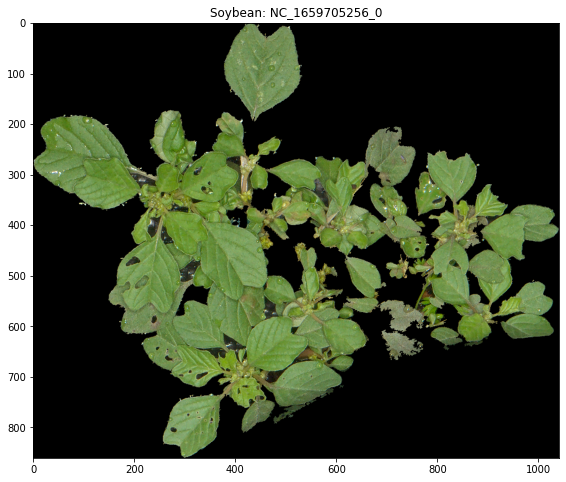

NC_1659705229_0


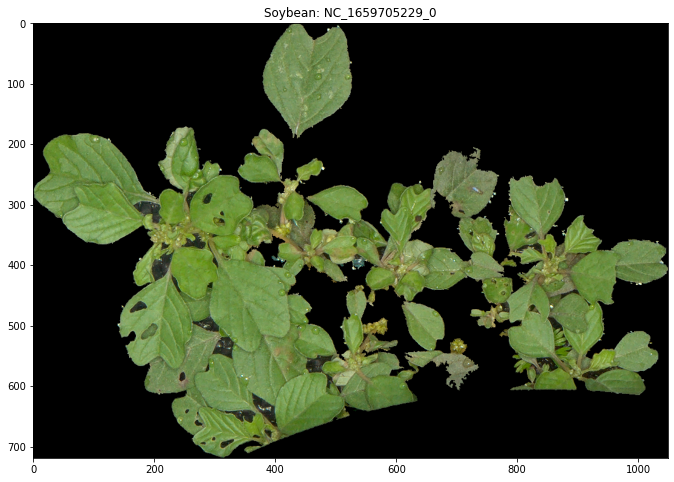

In [21]:
# view images

for sam in viewdf.iterrows():
    path = sam[1]["path"]
    com_name = sam[1]["common_name"]
    cutout_id = sam[1]["cutout_id"]
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(12,8))
    print(cutout_id)
    plt.imshow(img)
    plt.title(f"{com_name}: {cutout_id}")
    
    plt.show()